In [5]:
!pip install cupy-cuda117

ERROR: Could not find a version that satisfies the requirement cupy-cuda117 (from versions: none)
ERROR: No matching distribution found for cupy-cuda117


## Train Model

In [24]:
import lightgbm as lgb
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from numpy import argmax
import numpy as np

from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, ModelMetadataServiceApi, DriftDetectorApi, BatchJobsApi, BatchJobDefinition
from seldon_deploy_sdk.auth import OIDCAuthenticator

In [9]:
iris = load_iris()
x, y = iris.data, iris.target

x_df = DataFrame(x, columns= iris.feature_names)
x_train, x_test, y_train, y_test = train_test_split(x_df, y, test_size=0.15)

In [10]:
# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 10,
    'num_class': 3
} 

In [11]:
# laoding data
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [12]:
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 127, number of used features: 4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.015546
[LightGBM] [Info] Start training from score -1.106517
[LightGBM] [Info] Start training from score -1.180625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 0.987854
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/josh/opt/anaconda3/envs/data-science/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [13]:
# prediction
y_pred = model.predict(x_test)

y_pred = argmax(y_pred, axis=1)
cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
 
print(cr)
print(cm) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.70      0.88      0.78         8
           2       0.89      0.73      0.80        11

    accuracy                           0.83        23
   macro avg       0.86      0.87      0.86        23
weighted avg       0.84      0.83      0.83        23

[[4 0 0]
 [0 7 1]
 [0 3 8]]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

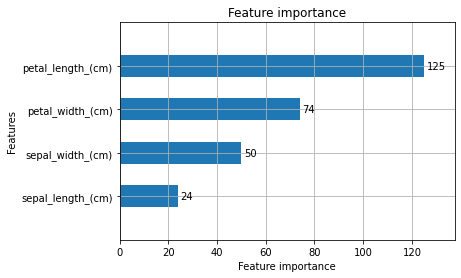

In [14]:
# plotting feature importance
lgb.plot_importance(model, height=.5)

In [15]:
model.save_model('./models-repository/lightgbm/1/model.txt')

## Create Triton Configuration

Triton requires a specific file structure (insert docs to file structure here). 

In [31]:
import os
REPO_PATH = os.path.abspath('model_repository')
os.makedirs(REPO_PATH, exist_ok=True)


In [69]:
def serialize_model(model, model_name):
    # The name of the model directory determines the name of the model as reported
    # by Triton
    model_dir = os.path.join(REPO_PATH, model_name)
    # We can store multiple versions of the model in the same directory. In our
    # case, we have just one version, so we will add a single directory, named '1'.
    version_dir = os.path.join(model_dir, '1')
    os.makedirs(version_dir, exist_ok=True)
    
    # The default filename for LightGBM models saved in txt format is 'model.txt'.
    # It is recommended that you use this filename to avoid having to specify a
    # name in the configuration file.
    model_file = os.path.join(version_dir, 'model.txt')
    model.save_model(model_file)
    
    return model_dir

In [37]:
lightgbm_model = serialize_model(model, 'lightgbm')

In [39]:
MAX_MEMORY_BYTES = 60_000_000
features = x_test.shape[1]
num_classes = np.unique(y_test).size
bytes_per_sample = (features + num_classes) * 4
max_batch_size = MAX_MEMORY_BYTES // bytes_per_sample

In [52]:
def generate_config(model_dir, deployment_type='gpu', storage_type='AUTO'):
    if deployment_type.lower() == 'cpu':
        instance_kind = 'KIND_CPU'
    else:
        instance_kind = 'KIND_GPU'

    config_text = f"""backend: "fil"
max_batch_size: {max_batch_size}
input [                                 
 {{  
    name: "input__0"
    data_type: TYPE_FP32
    dims: [ {features} ]                    
  }} 
]
output [
 {{
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ {num_classes} ]
  }}
]
instance_group [{{ kind: {instance_kind} }}]
parameters [
  {{
    key: "model_type"
    value: {{ string_value: "lightgbm" }}
  }},
  {{
    key: "predict_proba"
    value: {{ string_value: "true" }}
  }},
  {{
    key: "output_class"
    value: {{ string_value: "true" }}
  }},
  {{
    key: "threshold"
    value: {{ string_value: "0.5" }}
  }},
  {{
    key: "storage_type"
    value: {{ string_value: "{storage_type}" }}
  }}
]

dynamic_batching {{
  max_queue_delay_microseconds: 100
}}"""
    config_path = os.path.join(model_dir, 'config.pbtxt')
    with open(config_path, 'w') as file_:
        file_.write(config_text)

    return config_path

In [53]:
generate_config(lightgbm_model, deployment_type='cpu')

'/Users/josh/Documents/job-2021/seldon/nVidia-triton/lightGBM/model_repository/lightgbm/config.pbtxt'

In [54]:
TRITON_IMAGE = 'nvcr.io/nvidia/tritonserver:21.12-py3'

In [55]:
!docker run -d -p 8000:8000 -p 8001:8001 -p 8002:8002 -v {REPO_PATH}:/models --name tritonserver {TRITON_IMAGE} tritonserver --model-repository=/models

57528039fb6c211467e77f350bb6cf706b27d8acd7dff299b0423e9dd09e1142


In [56]:
import time
import tritonclient.grpc as triton_grpc
from tritonclient import utils as triton_utils
HOST = 'localhost'
PORT = 8001
TIMEOUT = 60

In [57]:
client = triton_grpc.InferenceServerClient(url=f'{HOST}:{PORT}')

In [50]:
# Wait for server to come online
server_start = time.time()
while True:
    try:
        if client.is_server_ready() or time.time() - server_start > TIMEOUT:
            break
    except triton_utils.InferenceServerException:
        pass
    time.sleep(1)

KeyboardInterrupt: 

In [58]:
def triton_predict(model_name, arr):
    triton_input = triton_grpc.InferInput('input__0', arr.shape, 'FP32')
    triton_input.set_data_from_numpy(arr)
    triton_output = triton_grpc.InferRequestedOutput('output__0')
    response = client.infer(model_name, model_version='1', inputs=[triton_input], outputs=[triton_output])
    return response.as_numpy('output__0')

In [70]:
triton_result = triton_predict('lightgbm', np.array([x_test.iloc[1]], dtype=np.float32))
local_result = model.predict(np.array([x_test.iloc[1]], dtype=np.float32))
print("Result computed on Triton: ")
print(triton_result)
print("\nResult computed locally: ")
print(local_result)
# cp.testing.assert_allclose(triton_result, local_result, rtol=1e-6, atol=1e-6)

Result computed on Triton: 
[[0.02687318 0.9340161  0.03911067]]

Result computed locally: 
[[0.02687316 0.93401617 0.03911067]]


In [71]:
!docker stop tritonserver

tritonserver


In [72]:
!docker rm tritonserver

tritonserver


### Upload to GCP example bucket

In [73]:
!gsutil cp -r model_repository gs://tom-seldon-examples/triton/lightgbm/model_repository 



Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update

Copying file://model_repository/lightgbm/config.pbtxt [Content-Type=application/octet-stream]...
Copying file://model_repository/lightgbm/1/model.txt [Content-Type=text/plain]...
/ [2 files][ 46.4 KiB/ 46.4 KiB]                                                
Operation completed over 2 objects/46.4 KiB.                                     


In [74]:
!gsutil ls gs://tom-seldon-examples/triton/lightgbm/

gs://tom-seldon-examples/triton/lightgbm/lightgbm.txt
gs://tom-seldon-examples/triton/lightgbm/model_repository/


## Create Test Seldon Prediction

In [ ]:
single_prediction = x_test.iloc[1]
single_row_array = single_prediction.to_numpy()
model.predict(single_prediction)
single_prediction.shape

In [ ]:
single_prediction

In [ ]:
{
   "inputs":[
      {
         "name":"INPUT0",
         "data":[
            1,
            2,
            3,
            4
         ],
         "datatype":"INT32",
         "shape":[
            1,
            4
         ]
      }
   ]
}

In [ ]:
{
  "inputs": [
    {
      "name": "Sepal length",
      "datatype": "FP32",
      "data": [6.8, 6.1],
      "shape": [2]
    },
    {
      "name": "Sepal width",
      "datatype": "FP32",
      "data": [2.8, 3.4],
      "shape": [2]
    },
    {
      "name": "Petal length",
      "datatype": "FP32",
      "data": [4.8, 4.5],
      "shape": [2]
    },
    {
      "name": "Petal width",
      "datatype": "FP32",
      "data": [1.4, 1.6],
      "shape": [2]
    }
  ]
}

In [ ]:
http://localhost:8080/seldon/default/lgb-classifier/api/v1.0/doc/

## Scale down things

kubectl scale deployment seldon-controller-manager --replicas 0 -n default

## Deploy to Seldon Deploy

In [78]:
SD_IP = "34.74.242.235"
config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = "client_credentials"
config.verify_ssl = False

auth = OIDCAuthenticator(config)
config.id_token = auth.authenticate()
seldon_api_client = ApiClient(configuration=config, authenticator=auth)

In [82]:
DEPLOYMENT_NAME = "lightgbm"
NAMESPACE = "seldon-demos"
MODEL_LOCATION = f"gs://tom-seldon-examples/triton/lightgbm"

PREPACKAGED_SERVER = "TRITON_SERVER"

CPU_REQUESTS = "1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "1"
MEMORY_LIMITS = "1Gi"

mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE,
        "labels": {
            "fluentd": "true"
        }
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "annotations": {
            "seldon.io/engine-seldon-log-messages-externally": "true"
        },
        "protocol":"kfserving",
        "transport": "rest",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{DEPLOYMENT_NAME}-container",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS,
                                            "nvidia.com/gpu":"0"
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS,
                                            "nvidia.com/gpu":"0"
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "implementation": PREPACKAGED_SERVER,
                    "modelUri": MODEL_LOCATION,
                    "name": f"{DEPLOYMENT_NAME}-container",
                    "envSecretRefName": "",
                    "endpoint": {
                        "type": "REST"
                    },
                    "parameters": [],
                    "children": [],
                    "logger": {
                        "mode": "all"
                    }
                }
            }
        ]
    },
    "status": {}
}

In [83]:
deployment_api = SeldonDeploymentsApi(seldon_api_client)
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': {'fluentd': 'true'},
              'managed_fields': None,
              'name': 'lightgbm',
              'namespace': 'seldon-demos',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
          'name': 'lightgbm',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [{'hpa_spec': None,
              